In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image
import os
import shutil
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define the path to the data
data_path = 'data/Unified'

# List the subfolders in the training data folder
subfolders = os.listdir(data_path)

# Initialize a dictionary to hold the count of images in each subfolder
image_counts_data = {}

# Count the number of images in each subfolder
for subfolder in subfolders:
    subfolder_path = os.path.join(data_path, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = len(os.listdir(subfolder_path))
        image_counts_data[subfolder] = num_images

# Display the results
print("Number of images in each class:")
for subfolder, count in image_counts_data.items():
    print(f"{subfolder}: {count}")

Number of images in each class (Training data):
glioma_tumor: 926
meningioma_tumor: 937
no_tumor: 500
pituitary_tumor: 901


In [3]:
# Paths
original_training_data_path = 'data/Unified'
augmented_training_data_path = 'data/Augmented'

# Initialize ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images of a specific class
def augment_images(class_name, target_count):
    class_path = os.path.join(original_training_data_path, class_name)
    augmented_class_path = os.path.join(augmented_training_data_path, class_name)
    
    # Create subfolder in augmented_training if it doesn't exist
    if not os.path.exists(augmented_class_path):
        os.makedirs(augmented_class_path)
    
    # List existing images
    existing_images = os.listdir(class_path)
    existing_count = len(existing_images)
    
    # Copy existing images to augmented_training
    for image_name in existing_images:
        src_path = os.path.join(class_path, image_name)
        dst_path = os.path.join(augmented_class_path, image_name)
        if not os.path.exists(dst_path):  # Check if image already exists in destination
            shutil.copy(src_path, dst_path)
    
    # Start augmentation until target_count is reached
    for i in range(target_count - existing_count):
        # Randomly select an image to augment
        image_name = np.random.choice(existing_images)
        image_path = os.path.join(class_path, image_name)
        img = image.load_img(image_path, target_size=(128, 128))
        
        # Convert to numpy array and add batch dimension
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        # Generate augmented image
        augmented_images = next(datagen.flow(x, batch_size=1))
        augmented_image = image.array_to_img(augmented_images[0])
        
        # Save augmented image
        save_path = os.path.join(augmented_class_path, f"aug_{i}_{image_name}")
        augmented_image.save(save_path)

# Function to copy images of a specific class
def copy_images(class_name):
    class_path = os.path.join(original_training_data_path, class_name)
    augmented_class_path = os.path.join(augmented_training_data_path, class_name)
    
    # Create subfolder in augmented_training if it doesn't exist
    if not os.path.exists(augmented_class_path):
        os.makedirs(augmented_class_path)
    
    # List existing images
    existing_images = os.listdir(class_path)
    
    # Copy existing images to augmented_training
    for image_name in existing_images:
        src_path = os.path.join(class_path, image_name)
        dst_path = os.path.join(augmented_class_path, image_name)
        if not os.path.exists(dst_path):  # Check if image already exists in destination
            shutil.copy(src_path, dst_path)

# Get the number of images in each class in the original training data
image_counts = {class_name: len(os.listdir(os.path.join(original_training_data_path, class_name))) 
                for class_name in os.listdir(original_training_data_path) 
                if os.path.isdir(os.path.join(original_training_data_path, class_name))}

# Find the class with the maximum number of images
max_count = max(image_counts.values())

# Check if augmentation for 'no_tumor' is needed
augmented_no_tumor_path = os.path.join(augmented_training_data_path, 'no_tumor')
if not os.path.exists(augmented_no_tumor_path) or len(os.listdir(augmented_no_tumor_path)) < max_count:
    # Create augmented_training folder if it doesn't exist
    if not os.path.exists(augmented_training_data_path):
        os.makedirs(augmented_training_data_path)
    
    augment_images('no_tumor', max_count)
else:
    print("Augmented images already exist. Skipping augmentation.")

# Copy all original training images to augmented_training
for class_name in image_counts.keys():
    if class_name != 'no_tumor':  # We've already handled no_tumor
        copy_images(class_name)

Augmented images already exist. Skipping augmentation.


In [20]:
# Define the path to the data
data_path = 'data/Augmented'

# List the subfolders in the training data folder
subfolders = os.listdir(data_path)

# Initialize a dictionary to hold the count of images in each subfolder
image_counts_data = {}

# Count the number of images in each subfolder
for subfolder in subfolders:
    subfolder_path = os.path.join(data_path, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = len(os.listdir(subfolder_path))
        image_counts_data[subfolder] = num_images

# Display the results
print("Number of images in each class after data augmentation:")
for subfolder, count in image_counts_data.items():
    print(f"{subfolder}: {count}")

Number of images in each class after data augmentation:
glioma_tumor: 926
meningioma_tumor: 937
no_tumor: 937
pituitary_tumor: 901


## Calculating class weights

In [4]:
# Classes
classes = list(image_counts.keys())

# Number of samples in each class
samples_per_class = [image_counts[cls] for cls in classes]

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=[cls for cls in classes for _ in range(image_counts[cls])])
class_weight_dict = dict(zip(classes, class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {'glioma_tumor': 0.8812095032397408, 'meningioma_tumor': 0.8708644610458911, 'no_tumor': 1.632, 'pituitary_tumor': 0.9056603773584906}


## Neural Networks

In [5]:
# Image dimensions
img_height, img_width = 128, 128
batch_size = 32

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # set the validation split
)

In [7]:
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # set as training data
)

validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # set as validation data
)

Found 2612 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


In [8]:
print(len(train_generator))

82


In [9]:
# Get a batch of images and labels
images, labels = train_generator[0]

# Get the first image and label from the batch
first_image = images[0]
first_label = labels[0]

# Convert the image array to a Pillow Image
first_image = Image.fromarray((first_image * 255).astype('uint8'))

# Show the image
#first_image.show()

# Print the label
print(f'Label: {first_label}')


Label: [0. 1. 0. 0.]


In [10]:
# Get the shape of the images
image_shape = train_generator.image_shape
print(f'Image Shape: {image_shape}')

# Get the number of batches per epoch
num_batches = len(train_generator)
print(f'Number of Batches per Epoch: {num_batches}')

# Get the total number of samples
num_samples = train_generator.n
print(f'Total Number of Samples: {num_samples}')

# Get the batch size
batch_size = train_generator.batch_size
print(f'Batch Size: {batch_size}')

Image Shape: (128, 128, 3)
Number of Batches per Epoch: 82
Total Number of Samples: 2612
Batch Size: 32


In [11]:
sample_image = images[10]
print(sample_image)

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00113512 0.00113512 0.00113512]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00431758 0.00431758 0.00431758]
  [0.00266152 0.00266152 0.00266152]
  [0.00120347 0.00120347 0.00120347]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.01028649 0.01028649 0.01028649]
  [0.00737039 0.00737039 0.00737039]
  [0.00463892 0.00463892 0.00463892]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


## Convolutional Neural Network (CNN)

In [12]:
# Get the class indices
class_indices = train_generator.class_indices

# Map class names to class indices
class_weight_indices = {class_indices[class_name]: weight for class_name, weight in class_weight_dict.items()}

In [13]:
# Set random seed
tf.random.set_seed(42)

# Build the model
model_1 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4, activation='softmax')
])

# Compile the model
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Train the model
history_1 = model_1.fit(train_generator, epochs=10, validation_data=validation_generator, class_weight=class_weight_indices)

Epoch 1/10
82/82 [==============================] - 25s 299ms/step - loss: 1.4295 - accuracy: 0.3637 - val_loss: 1.3835 - val_accuracy: 0.3190
Epoch 2/10
82/82 [==============================] - 21s 252ms/step - loss: 1.1870 - accuracy: 0.4870 - val_loss: 1.2459 - val_accuracy: 0.3788
Epoch 3/10
82/82 [==============================] - 21s 251ms/step - loss: 1.1149 - accuracy: 0.5333 - val_loss: 1.2986 - val_accuracy: 0.3604
Epoch 4/10
82/82 [==============================] - 21s 257ms/step - loss: 1.0933 - accuracy: 0.5513 - val_loss: 1.3011 - val_accuracy: 0.4248
Epoch 5/10
82/82 [==============================] - 21s 257ms/step - loss: 1.0696 - accuracy: 0.5647 - val_loss: 1.2309 - val_accuracy: 0.4233
Epoch 6/10
82/82 [==============================] - 21s 255ms/step - loss: 1.0272 - accuracy: 0.5846 - val_loss: 1.5588 - val_accuracy: 0.3236
Epoch 7/10
82/82 [==============================] - 21s 260ms/step - loss: 1.0291 - accuracy: 0.5884 - val_loss: 1.2641 - val_accuracy: 0.4049

The accuracy on the train data is much higher than the validation accuracy, so we will try other configurations.

In [14]:
# Set random seed
tf.random.set_seed(42)

model_2 = keras.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_2 = model_2.fit(train_generator, epochs=10, validation_data=validation_generator, class_weight=class_weight_indices)

Epoch 1/10
82/82 [==============================] - 28s 335ms/step - loss: 1.3644 - accuracy: 0.3250 - val_loss: 1.4796 - val_accuracy: 0.2531
Epoch 2/10
82/82 [==============================] - 26s 322ms/step - loss: 1.1454 - accuracy: 0.4958 - val_loss: 1.3095 - val_accuracy: 0.4080
Epoch 3/10
82/82 [==============================] - 27s 326ms/step - loss: 1.0419 - accuracy: 0.5701 - val_loss: 1.3390 - val_accuracy: 0.3834
Epoch 4/10
82/82 [==============================] - 27s 326ms/step - loss: 0.9622 - accuracy: 0.6026 - val_loss: 1.2222 - val_accuracy: 0.4141
Epoch 5/10
82/82 [==============================] - 27s 325ms/step - loss: 0.9452 - accuracy: 0.6141 - val_loss: 1.3156 - val_accuracy: 0.4202
Epoch 6/10
82/82 [==============================] - 27s 327ms/step - loss: 0.8944 - accuracy: 0.6340 - val_loss: 1.2543 - val_accuracy: 0.4248
Epoch 7/10
82/82 [==============================] - 26s 317ms/step - loss: 0.8895 - accuracy: 0.6390 - val_loss: 1.3458 - val_accuracy: 0.4202

In [15]:
# Set random seed
tf.random.set_seed(42)
# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Build the model
model_3 = keras.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Compile the model
model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history_3 = model_3.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weight_indices,
    callbacks=[early_stopping]
)

Epoch 1/10
82/82 [==============================] - 30s 344ms/step - loss: 5.1008 - accuracy: 0.3748 - val_loss: 7.1322 - val_accuracy: 0.2761
Epoch 2/10
82/82 [==============================] - 28s 342ms/step - loss: 6.0232 - accuracy: 0.4146 - val_loss: 17.3816 - val_accuracy: 0.2761
Epoch 3/10
82/82 [==============================] - 28s 339ms/step - loss: 4.9953 - accuracy: 0.4541 - val_loss: 19.0342 - val_accuracy: 0.2761
Epoch 4/10
82/82 [==============================] - 28s 338ms/step - loss: 4.4461 - accuracy: 0.4801 - val_loss: 19.8111 - val_accuracy: 0.2776


In [16]:
# Set random seed
tf.random.set_seed(42)

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Build the model
model_4 = keras.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Compile the model
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history_4 = model_4.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weight_indices
)

Epoch 1/10
82/82 [==============================] - 30s 340ms/step - loss: 1.9265 - accuracy: 0.4089 - val_loss: 1.7362 - val_accuracy: 0.2761
Epoch 2/10
82/82 [==============================] - 28s 340ms/step - loss: 1.8100 - accuracy: 0.4414 - val_loss: 2.7542 - val_accuracy: 0.2761
Epoch 3/10
82/82 [==============================] - 28s 337ms/step - loss: 1.7643 - accuracy: 0.4602 - val_loss: 4.0133 - val_accuracy: 0.2761
Epoch 4/10
82/82 [==============================] - 28s 339ms/step - loss: 1.7579 - accuracy: 0.4713 - val_loss: 4.1010 - val_accuracy: 0.2791
Epoch 5/10
82/82 [==============================] - 28s 341ms/step - loss: 1.7180 - accuracy: 0.4832 - val_loss: 3.7306 - val_accuracy: 0.3098
Epoch 6/10
82/82 [==============================] - 28s 340ms/step - loss: 1.5737 - accuracy: 0.5054 - val_loss: 2.6407 - val_accuracy: 0.3298
Epoch 7/10
82/82 [==============================] - 28s 334ms/step - loss: 1.6311 - accuracy: 0.5203 - val_loss: 2.3437 - val_accuracy: 0.3574

In [17]:
# Set random seed
tf.random.set_seed(42)

# Load MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), 
                                               include_top=False, 
                                               weights="imagenet")
base_model.trainable = False

# Create a new model with custom layers
model_5 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model with a smaller learning rate
model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy', 
                metrics=['mae', 'accuracy'])

# Train the model with class weights
history_5 = model_5.fit(train_generator, 
                        epochs=20, 
                        validation_data=validation_generator, 
                        class_weight=class_weight_indices)

Epoch 1/20
82/82 [==============================] - 30s 334ms/step - loss: 1.4705 - mae: 0.3543 - accuracy: 0.3281 - val_loss: 1.3084 - val_mae: 0.3412 - val_accuracy: 0.3850
Epoch 2/20
82/82 [==============================] - 25s 309ms/step - loss: 1.2526 - mae: 0.3264 - accuracy: 0.4273 - val_loss: 1.2191 - val_mae: 0.3257 - val_accuracy: 0.4310
Epoch 3/20
82/82 [==============================] - 24s 288ms/step - loss: 1.0912 - mae: 0.2981 - accuracy: 0.5241 - val_loss: 1.0943 - val_mae: 0.2988 - val_accuracy: 0.5506
Epoch 4/20
82/82 [==============================] - 24s 287ms/step - loss: 1.0369 - mae: 0.2837 - accuracy: 0.5651 - val_loss: 1.1274 - val_mae: 0.3020 - val_accuracy: 0.5169
Epoch 5/20
82/82 [==============================] - 24s 293ms/step - loss: 0.9506 - mae: 0.2656 - accuracy: 0.6018 - val_loss: 1.0563 - val_mae: 0.2889 - val_accuracy: 0.5567
Epoch 6/20
82/82 [==============================] - 24s 288ms/step - loss: 0.9035 - mae: 0.2534 - accuracy: 0.6378 - val_loss

In [27]:
# Set random seed
tf.random.set_seed(42)

# Load MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), 
                                               include_top=False, 
                                               weights="imagenet")

# Unfreeze the base model
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Create a new model with custom layers
model_6 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model with a smaller learning rate
model_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                loss='categorical_crossentropy', 
                metrics=[
                    'mae', 
                    'accuracy', 
                    tf.keras.metrics.Precision(), 
                    tf.keras.metrics.Recall()
                ])

# Continue training
history_6 = model_6.fit(train_generator, 
                             epochs=15, 
                             validation_data=validation_generator, 
                             class_weight=class_weight_indices)

Epoch 1/15
82/82 [==============================] - 18s 195ms/step - loss: 1.6130 - mae: 0.3585 - accuracy: 0.3151 - precision_7: 0.3210 - recall_7: 0.1593 - val_loss: 1.6322 - val_mae: 0.3535 - val_accuracy: 0.3374 - val_precision_7: 0.3520 - val_recall_7: 0.2117
Epoch 2/15
82/82 [==============================] - 15s 184ms/step - loss: 1.1748 - mae: 0.3050 - accuracy: 0.4858 - precision_7: 0.5742 - recall_7: 0.3185 - val_loss: 1.4898 - val_mae: 0.3326 - val_accuracy: 0.3558 - val_precision_7: 0.4005 - val_recall_7: 0.2684
Epoch 3/15
82/82 [==============================] - 15s 188ms/step - loss: 0.9622 - mae: 0.2636 - accuracy: 0.6095 - precision_7: 0.6960 - recall_7: 0.4609 - val_loss: 1.3965 - val_mae: 0.3131 - val_accuracy: 0.4187 - val_precision_7: 0.4426 - val_recall_7: 0.3313
Epoch 4/15
82/82 [==============================] - 15s 188ms/step - loss: 0.8397 - mae: 0.2347 - accuracy: 0.6646 - precision_7: 0.7496 - recall_7: 0.5582 - val_loss: 1.2766 - val_mae: 0.2950 - val_accura

## Confusion Matrix

In [51]:
# Predict using the validation generator
validation_generator.reset() # To ensure it's starting from the beginning
predictions = model_6.predict(validation_generator, steps=len(validation_generator))
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

21/21 [==============================] - 3s 130ms/step


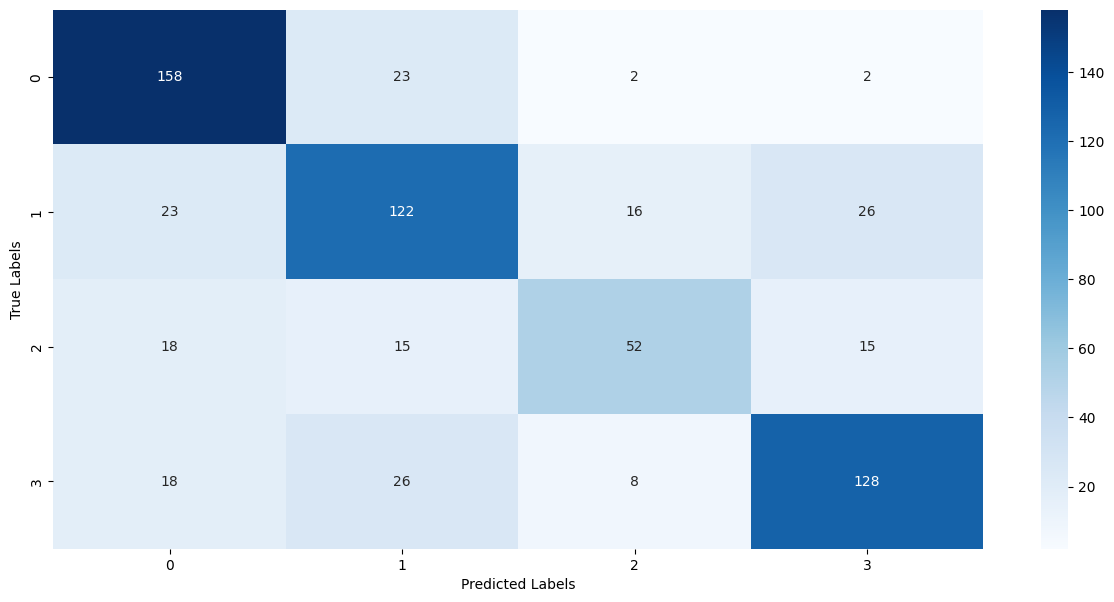

In [52]:
plt.figure(figsize=(15,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [53]:
print(classification_report(true_classes, predicted_classes, target_names=class_indices.keys()))

                  precision    recall  f1-score   support

    glioma_tumor       0.73      0.85      0.79       185
meningioma_tumor       0.66      0.65      0.65       187
        no_tumor       0.67      0.52      0.58       100
 pituitary_tumor       0.75      0.71      0.73       180

        accuracy                           0.71       652
       macro avg       0.70      0.68      0.69       652
    weighted avg       0.70      0.71      0.70       652



In [59]:
print(validation_generator.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
